## Load Data Set

In [1]:
import zipfile
import os
import numpy as np
import pathlib
import pandas as pd
from math import ceil
import tensorflow as tf
import numpy as np
import IPython.display as display
import keras
from keras import backend as K
from matplotlib import pyplot as plt
from keras.utils import to_categorical


print(tf.__version__)

root_path = './'

models_path = os.path.join(root_path, 'saved_models_mnist_v8')
if not os.path.exists(models_path):
    os.mkdir(models_path)


mnist = keras.datasets.mnist

(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = (x_train / 127.5) - 1, (x_test / 127.5) - 1


print(x_train.shape, y_train.shape)
x_train = np.expand_dims(x_train, -1)
y_train = to_categorical(y_train)
print(x_train.shape, y_train.shape)


BATCH_SIZE = 256


def custom_loader():
    trainset_size = x_train.shape[0]

    p = 0
    while True:

        idx_from = (p * BATCH_SIZE) % trainset_size

        idx_to = idx_from + BATCH_SIZE

        batch_x = x_train[idx_from: idx_to]
        batch_y = y_train[idx_from: idx_to]

        p += 1

        yield batch_x, batch_y


custom_gen = custom_loader()
for i in range(3):
    batch_x, batch_y = next(custom_gen)
    print(batch_x.shape, batch_y.shape)

Using TensorFlow backend.


1.13.1
(60000, 28, 28) (60000,)
(60000, 28, 28, 1) (60000, 10)
(256, 28, 28, 1) (256, 10)
(256, 28, 28, 1) (256, 10)
(256, 28, 28, 1) (256, 10)


## Wasserstein GAN

In [2]:
def d_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

## Model Design

In [3]:
enc_len = 0
age_len = 0
img_shape = (28, 28, 1)
width, height, depth = (28, 28, 1)
img_len = np.prod(img_shape)
latent_dim = enc_len + age_len + img_len
noise_len = 100
input_dim = enc_len + age_len + noise_len
cond_len = enc_len + age_len


def build_discriminator():
    conv = keras.Sequential([
        # conv block 1
        keras.layers.Conv2D(
            filters=16,
            kernel_size=(3, 3),
            strides=2,
            input_shape=img_shape
        ),
        keras.layers.Activation(tf.nn.leaky_relu),
        keras.layers.BatchNormalization(),

        # conv block 2
        keras.layers.Conv2D(
            filters=32,
            kernel_size=(3, 3),
            strides=2
        ),
        keras.layers.Activation(tf.nn.leaky_relu),
        keras.layers.BatchNormalization(),
        
        # conv block 3
        keras.layers.Conv2D(
            filters=3,
            kernel_size=(3, 3),
            strides=2
        ),
        keras.layers.Activation(tf.nn.leaky_relu),
    ])
    
    conv.summary()
    
    model = keras.Sequential([
        # dense 1
#         keras.layers.Dense(128),
#         keras.layers.Activation(tf.nn.relu),
        
        # output
        keras.layers.Dense(1, input_shape=(12,)),
        keras.layers.Activation(tf.nn.sigmoid),
    ])
    
#     clf = keras.Sequential([
#         # dense 1
#         keras.layers.Dense(128, input_shape=(27+128+8,)),
#         keras.layers.Activation(tf.nn.relu),
        
#         # output
#         keras.layers.Dense(age_len),
#         keras.layers.Activation(tf.nn.softmax),
#     ])
    
    model.summary()
    
#     # condition
#     c1 = keras.layers.Input(shape=(enc_len,))
#     c2 = keras.layers.Input(shape=(age_len,))
    
    # image
    z = keras.layers.Input(shape=img_shape)
    
    # convolution
    zout = conv(z)
    
    # flatten image
    z_flat = keras.layers.Flatten()(zout)
    
    # concatenation
#     inputs = keras.layers.concatenate([z_flat])
    
    # real or fake
    outputs = model(z_flat)
    
    # age label
#     classes = clf(inputs)
    
    
    return keras.models.Model(z, outputs)


def build_generator():
    
    conv = keras.Sequential([
        # transpose conv block 1
        keras.layers.Conv2DTranspose(
            filters=16,
            kernel_size=(3, 3),
            strides=1,
            input_shape=(11, 11, 1)
        ),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.BatchNormalization(),
        
        # transpose conv block 2
        keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=(3, 3),
            strides=2
        ),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.BatchNormalization(),
        
        # transpose conv block 3
        keras.layers.Conv2DTranspose(
            filters=32,
            kernel_size=(2, 2),
            strides=1
        ),
        keras.layers.Activation(tf.nn.relu),
        keras.layers.BatchNormalization(),

        # transpose conv block 4
        keras.layers.Conv2DTranspose(
            filters=1,
            kernel_size=(1, 1),
            strides=1
        ),
        
        # output
        keras.layers.Activation(tf.nn.tanh)
    ])
    
    conv.summary()
    
    model = keras.Sequential([
        # dense 1
        keras.layers.Dense(121, input_shape=(input_dim,)),
        keras.layers.Activation(tf.nn.relu),
        
        # reshape 1d to 3d
        keras.layers.Reshape((11, 11, 1))
    ])
    
    model.summary()
    
#     # condition
#     c1 = keras.layers.Input(shape=(enc_len,))
#     c2 = keras.layers.Input(shape=(age_len,))
    
    # noise
    x = keras.layers.Input(shape=(noise_len,))

    # concatenation
#     inputs = keras.layers.concatenate([x])
    
    # flat dense output
    out_1 = model(x)
    
    # transpose conv output
    outputs = conv(out_1)
    
    return keras.models.Model(x, outputs)


discriminator = build_discriminator()
generator = build_generator()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 13, 13, 16)        160       
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 16)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 13, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 32)          4640      
_________________________________________________________________
activation_2 (Activation)    (None, 6, 6, 32)          0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 6, 6, 32)          128       
_________________________________________________________________
conv

In [4]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 11, 11, 1)         12221     
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         9281      
Total params: 21,502
Trainable params: 21,342
Non-trainable params: 160
_________________________________________________________________


In [5]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 2, 2, 3)           5859      
_________________________________________________________________
flatten_1 (Flatten)          (None, 12)                0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 13        
Total params: 5,872
Trainable params: 5,776
Non-trainable params: 96
_________________________________________________________________


## Generative Adversarial Network

In [6]:
GLR = 0.01  # generator
DLR = 0.01  # discriminator


discriminator.compile(
    optimizer=keras.optimizers.Adam(DLR, 0.5),
    loss=d_loss,
    metrics=['accuracy']
)


# # condition
# c1 = keras.layers.Input(shape=(enc_len,))
# c2 = keras.layers.Input(shape=(age_len,))

# noise
x = keras.layers.Input(shape=(noise_len,))

# freeze discriminator
discriminator.trainable = False

# output
z = generator(x)
out = discriminator(z)

# GAN
gan = keras.models.Model(inputs=x, outputs=out)

gan.compile(
    optimizer=keras.optimizers.Adam(GLR , 0.5),
    loss=d_loss,
    metrics=['accuracy'])

In [7]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_2 (Model)              (None, 28, 28, 1)         21502     
_________________________________________________________________
model_1 (Model)              (None, 1)                 5872      
Total params: 27,374
Trainable params: 21,342
Non-trainable params: 6,032
_________________________________________________________________


## Visualization Method

In [8]:
# from google.colab import drive
import os


# drive.mount('/content/gdrive', force_remount=True)

root_path = './'
tgt_pth = os.path.join(root_path, 'visualize_mnist-v20')

if not os.path.exists(tgt_pth):
  os.mkdir(tgt_pth)

In [9]:
def visualizeGAN(e, z_real, z_fake):

    fig, axes = plt.subplots(4, 4, figsize=(20, 18))

    r_real = 0
    r_fake = 0
    for row, axe in enumerate(axes):
        for col, cell in enumerate(axe):
            if row % 2 == 0:
                cell.imshow(
                    np.squeeze(
                        0.5 * z_real[r_real * 4 + col] + 0.5,
                        axis=-1
                    ),
                    cmap='gray'
                )
            else:
                cell.imshow(
                    np.squeeze(
                        0.5 * z_fake[r_fake * 4 + col] + 0.5,
                        axis=-1
                    ),
                    cmap='gray'
                )

            cell.axis("off")

        if row % 2 == 0:
            r_real += 1
        else:
            r_fake += 1

    plt.axis("off")
    plt.tight_layout()

    fig.savefig(os.path.join(tgt_pth, '{}.jpg'.format(str(e).zfill(3))))
    
    plt.close()

## Load Batch

In [10]:
def load_noise():
    
    y_real = tf.ones((BATCH_SIZE,))
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allocator_type = 'BFC'
    config.gpu_options.per_process_gpu_memory_fraction = 0.40

    with tf.Session(config=config) as sess:
        tf.initialize_all_variables().run()
        
        # run once
        y_real = y_real.eval()

        while True:
            batch_x, batch_y = next(custom_gen)

            sz = batch_x.shape[0]

            if sz != BATCH_SIZE:
                continue
            
            # fake data
            x = tf.random.normal((sz, noise_len,)).eval()
            
            yield x, y_real


def load_batch():
    
    y_fake = tf.zeros((BATCH_SIZE,))
    y_real = tf.ones((BATCH_SIZE,))
    
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allocator_type = 'BFC'
    config.gpu_options.per_process_gpu_memory_fraction = 0.40

    with tf.Session(config=config) as sess:
        tf.initialize_all_variables().run()
        
        # run once
        y_fake = y_fake.eval()
        y_real = y_real.eval()

        while True:
            batch_x, batch_y = next(custom_gen)

            sz = batch_x.shape[0]

            if sz != BATCH_SIZE:
                continue
            
            # fake data
            x = tf.random.normal((sz, noise_len,)).eval()
            z_fake = generator.predict(x)

            # real data
            z_real = batch_x

            yield x, z_fake, y_fake, z_real, y_real

## Train Model

In [11]:
EPOCHS = 1000
STEPS = 1  # 60000 // BATCH_SIZE


train_loss_g = []
train_loss_d = []

train_acc_g = []
train_acc_d = []


disc_itr = load_batch()
gen_itr = load_noise()


# epochs
for e in range(EPOCHS):

    #batches
    loss = []
    acc = []

    for p in range(STEPS):
        
        x, z_fake, y_fake, z_real, y_real = next(disc_itr)

        # train
        loss_2, acc_2 = discriminator.train_on_batch(z_real, y_real)
        loss_1, acc_1 = discriminator.train_on_batch(z_fake, y_fake)

        batch_loss = 0.5 * (loss_1 + loss_2)
        batch_acc = 0.5 * (acc_1 + acc_2)

        loss.append(batch_loss)
        acc.append(batch_acc)

    train_loss_d.append(np.mean(np.array(loss)))
    train_acc_d.append(np.mean(np.array(acc)))

    #batches
    loss = []
    acc = []

    for p in range(STEPS):

        x, y_true = next(gen_itr)

        # train
        loss_1, acc_1 = gan.train_on_batch(x, y_true)

        loss.append(loss_1)
        acc.append(acc_1)

    train_loss_g.append(np.mean(np.array(loss)))
    train_acc_g.append(np.mean(np.array(acc)))


    print("E: {}, D:[ACC: %{:.2f}, LOSS: {:.2f}], G:[ACC: %{:.2f}, LOSS: {:.2f}]".format(
          e,
          train_acc_d[-1] * 100,
          train_loss_d[-1] * 100,
          train_acc_g[-1] * 100,
          train_loss_g[-1] * 100
      ))

    if e % 100 == 0:
        ## visualize results
        x, z_fake, y_fake, z_real, y_real = next(disc_itr)
        visualizeGAN(e, z_real, z_fake)
        
        ## save model
        pth = os.path.join(models_path, 'gan.h5')
        gan.save(pth)

        pth = os.path.join(models_path, 'generator-{}-{}-{}.h5'.format(e, train_loss_g[-1], train_acc_g[-1]))
        generator.save(pth)

        pth = os.path.join(models_path, 'discriminator.h5')
        discriminator.save(pth)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


E: 0, D:[ACC: %31.84, LOSS: 142.88], G:[ACC: %28.52, LOSS: 145.26]
E: 1, D:[ACC: %52.54, LOSS: 102.12], G:[ACC: %15.23, LOSS: 216.80]
E: 2, D:[ACC: %61.52, LOSS: 90.24], G:[ACC: %46.48, LOSS: 102.26]
E: 3, D:[ACC: %59.38, LOSS: 80.37], G:[ACC: %46.09, LOSS: 91.71]
E: 4, D:[ACC: %74.61, LOSS: 46.63], G:[ACC: %15.62, LOSS: 161.99]
E: 5, D:[ACC: %63.48, LOSS: 66.06], G:[ACC: %16.80, LOSS: 147.90]
E: 6, D:[ACC: %67.97, LOSS: 59.86], G:[ACC: %16.41, LOSS: 144.44]
E: 7, D:[ACC: %65.82, LOSS: 61.05], G:[ACC: %19.53, LOSS: 140.79]
E: 8, D:[ACC: %67.38, LOSS: 61.71], G:[ACC: %21.48, LOSS: 138.95]
E: 9, D:[ACC: %81.64, LOSS: 39.77], G:[ACC: %7.42, LOSS: 194.65]
E: 10, D:[ACC: %89.26, LOSS: 28.19], G:[ACC: %8.59, LOSS: 217.31]
E: 11, D:[ACC: %73.24, LOSS: 47.25], G:[ACC: %12.11, LOSS: 185.68]
E: 12, D:[ACC: %66.41, LOSS: 59.24], G:[ACC: %26.95, LOSS: 133.71]
E: 13, D:[ACC: %71.09, LOSS: 50.42], G:[ACC: %19.53, LOSS: 148.15]
E: 14, D:[ACC: %84.18, LOSS: 35.18], G:[ACC: %7.81, LOSS: 216.43]
E: 15, 

E: 123, D:[ACC: %62.30, LOSS: 64.38], G:[ACC: %14.06, LOSS: 130.31]
E: 124, D:[ACC: %61.33, LOSS: 65.17], G:[ACC: %21.48, LOSS: 119.07]
E: 125, D:[ACC: %66.41, LOSS: 60.37], G:[ACC: %20.31, LOSS: 117.04]
E: 126, D:[ACC: %64.06, LOSS: 64.04], G:[ACC: %21.09, LOSS: 130.42]
E: 127, D:[ACC: %67.77, LOSS: 59.65], G:[ACC: %21.48, LOSS: 123.89]
E: 128, D:[ACC: %61.91, LOSS: 65.88], G:[ACC: %25.78, LOSS: 115.05]
E: 129, D:[ACC: %63.28, LOSS: 64.64], G:[ACC: %21.88, LOSS: 119.97]
E: 130, D:[ACC: %71.09, LOSS: 57.77], G:[ACC: %27.34, LOSS: 115.13]
E: 131, D:[ACC: %56.25, LOSS: 73.03], G:[ACC: %24.22, LOSS: 118.82]
E: 132, D:[ACC: %70.12, LOSS: 58.85], G:[ACC: %17.58, LOSS: 143.90]
E: 133, D:[ACC: %66.99, LOSS: 62.71], G:[ACC: %18.36, LOSS: 126.10]
E: 134, D:[ACC: %62.50, LOSS: 67.21], G:[ACC: %23.83, LOSS: 117.17]
E: 135, D:[ACC: %67.38, LOSS: 59.38], G:[ACC: %30.86, LOSS: 107.85]
E: 136, D:[ACC: %61.91, LOSS: 63.13], G:[ACC: %21.88, LOSS: 112.32]
E: 137, D:[ACC: %64.65, LOSS: 63.93], G:[ACC: %2

E: 244, D:[ACC: %58.79, LOSS: 67.04], G:[ACC: %14.45, LOSS: 120.02]
E: 245, D:[ACC: %70.51, LOSS: 55.78], G:[ACC: %8.59, LOSS: 135.97]
E: 246, D:[ACC: %68.55, LOSS: 62.25], G:[ACC: %13.67, LOSS: 124.39]
E: 247, D:[ACC: %51.56, LOSS: 74.39], G:[ACC: %21.48, LOSS: 108.75]
E: 248, D:[ACC: %62.89, LOSS: 62.92], G:[ACC: %21.48, LOSS: 114.58]
E: 249, D:[ACC: %66.99, LOSS: 60.49], G:[ACC: %19.14, LOSS: 118.59]
E: 250, D:[ACC: %73.63, LOSS: 57.49], G:[ACC: %13.28, LOSS: 123.37]
E: 251, D:[ACC: %69.73, LOSS: 59.09], G:[ACC: %16.02, LOSS: 120.06]
E: 252, D:[ACC: %66.80, LOSS: 62.08], G:[ACC: %17.97, LOSS: 116.13]
E: 253, D:[ACC: %60.55, LOSS: 66.99], G:[ACC: %15.23, LOSS: 116.08]
E: 254, D:[ACC: %56.45, LOSS: 67.93], G:[ACC: %12.89, LOSS: 124.52]
E: 255, D:[ACC: %67.19, LOSS: 60.45], G:[ACC: %7.81, LOSS: 127.58]
E: 256, D:[ACC: %65.23, LOSS: 60.25], G:[ACC: %13.28, LOSS: 120.03]
E: 257, D:[ACC: %67.58, LOSS: 61.34], G:[ACC: %13.28, LOSS: 119.83]
E: 258, D:[ACC: %54.88, LOSS: 70.55], G:[ACC: %15.

E: 365, D:[ACC: %63.67, LOSS: 64.13], G:[ACC: %12.89, LOSS: 125.86]
E: 366, D:[ACC: %67.58, LOSS: 61.23], G:[ACC: %14.84, LOSS: 120.91]
E: 367, D:[ACC: %68.36, LOSS: 58.40], G:[ACC: %16.02, LOSS: 115.64]
E: 368, D:[ACC: %66.99, LOSS: 60.98], G:[ACC: %16.41, LOSS: 121.01]
E: 369, D:[ACC: %68.36, LOSS: 58.70], G:[ACC: %13.67, LOSS: 121.19]
E: 370, D:[ACC: %67.38, LOSS: 61.81], G:[ACC: %19.92, LOSS: 114.31]
E: 371, D:[ACC: %71.68, LOSS: 57.31], G:[ACC: %17.19, LOSS: 122.83]
E: 372, D:[ACC: %71.48, LOSS: 58.66], G:[ACC: %16.02, LOSS: 124.22]
E: 373, D:[ACC: %63.67, LOSS: 62.21], G:[ACC: %14.45, LOSS: 123.43]
E: 374, D:[ACC: %62.70, LOSS: 64.77], G:[ACC: %10.94, LOSS: 139.65]
E: 375, D:[ACC: %68.36, LOSS: 61.18], G:[ACC: %7.81, LOSS: 133.18]
E: 376, D:[ACC: %68.75, LOSS: 58.00], G:[ACC: %5.08, LOSS: 144.14]
E: 377, D:[ACC: %68.36, LOSS: 57.79], G:[ACC: %9.38, LOSS: 138.08]
E: 378, D:[ACC: %61.52, LOSS: 63.61], G:[ACC: %18.36, LOSS: 121.83]
E: 379, D:[ACC: %69.53, LOSS: 57.83], G:[ACC: %14.0

E: 486, D:[ACC: %69.53, LOSS: 56.83], G:[ACC: %8.59, LOSS: 137.63]
E: 487, D:[ACC: %72.85, LOSS: 53.90], G:[ACC: %9.77, LOSS: 132.99]
E: 488, D:[ACC: %62.11, LOSS: 62.94], G:[ACC: %14.06, LOSS: 136.63]
E: 489, D:[ACC: %61.72, LOSS: 64.27], G:[ACC: %8.59, LOSS: 136.15]
E: 490, D:[ACC: %65.43, LOSS: 62.41], G:[ACC: %4.30, LOSS: 141.26]
E: 491, D:[ACC: %70.12, LOSS: 58.71], G:[ACC: %8.59, LOSS: 133.10]
E: 492, D:[ACC: %70.70, LOSS: 55.37], G:[ACC: %12.50, LOSS: 131.80]
E: 493, D:[ACC: %73.63, LOSS: 50.83], G:[ACC: %10.94, LOSS: 138.53]
E: 494, D:[ACC: %64.84, LOSS: 64.66], G:[ACC: %14.84, LOSS: 127.68]
E: 495, D:[ACC: %71.48, LOSS: 55.89], G:[ACC: %13.28, LOSS: 135.70]
E: 496, D:[ACC: %64.65, LOSS: 61.98], G:[ACC: %12.50, LOSS: 138.12]
E: 497, D:[ACC: %60.16, LOSS: 69.03], G:[ACC: %10.55, LOSS: 130.92]
E: 498, D:[ACC: %73.24, LOSS: 54.02], G:[ACC: %10.94, LOSS: 131.67]
E: 499, D:[ACC: %68.36, LOSS: 58.39], G:[ACC: %12.89, LOSS: 129.58]
E: 500, D:[ACC: %67.38, LOSS: 59.33], G:[ACC: %12.89,

E: 607, D:[ACC: %65.04, LOSS: 64.35], G:[ACC: %12.89, LOSS: 136.37]
E: 608, D:[ACC: %69.92, LOSS: 57.95], G:[ACC: %10.94, LOSS: 134.42]
E: 609, D:[ACC: %73.44, LOSS: 52.18], G:[ACC: %6.25, LOSS: 144.20]
E: 610, D:[ACC: %68.75, LOSS: 58.36], G:[ACC: %19.14, LOSS: 119.54]
E: 611, D:[ACC: %71.48, LOSS: 55.45], G:[ACC: %14.45, LOSS: 135.53]
E: 612, D:[ACC: %72.46, LOSS: 55.78], G:[ACC: %9.38, LOSS: 136.63]
E: 613, D:[ACC: %60.74, LOSS: 66.03], G:[ACC: %13.28, LOSS: 127.22]
E: 614, D:[ACC: %68.36, LOSS: 58.64], G:[ACC: %14.45, LOSS: 122.38]
E: 615, D:[ACC: %72.46, LOSS: 54.65], G:[ACC: %12.89, LOSS: 132.96]
E: 616, D:[ACC: %70.51, LOSS: 57.41], G:[ACC: %7.42, LOSS: 147.76]
E: 617, D:[ACC: %71.29, LOSS: 56.84], G:[ACC: %10.94, LOSS: 145.89]
E: 618, D:[ACC: %72.07, LOSS: 55.53], G:[ACC: %12.11, LOSS: 129.19]
E: 619, D:[ACC: %68.75, LOSS: 60.95], G:[ACC: %12.11, LOSS: 128.89]
E: 620, D:[ACC: %74.80, LOSS: 53.74], G:[ACC: %10.94, LOSS: 131.56]
E: 621, D:[ACC: %65.23, LOSS: 59.60], G:[ACC: %14.8

E: 728, D:[ACC: %73.05, LOSS: 52.71], G:[ACC: %12.11, LOSS: 145.34]
E: 729, D:[ACC: %66.99, LOSS: 62.13], G:[ACC: %10.55, LOSS: 136.17]
E: 730, D:[ACC: %70.31, LOSS: 55.98], G:[ACC: %7.81, LOSS: 143.49]
E: 731, D:[ACC: %69.34, LOSS: 57.54], G:[ACC: %11.33, LOSS: 134.91]
E: 732, D:[ACC: %69.73, LOSS: 58.11], G:[ACC: %15.62, LOSS: 128.05]
E: 733, D:[ACC: %74.61, LOSS: 52.61], G:[ACC: %9.77, LOSS: 133.81]
E: 734, D:[ACC: %74.02, LOSS: 54.16], G:[ACC: %7.03, LOSS: 140.05]
E: 735, D:[ACC: %72.07, LOSS: 55.58], G:[ACC: %19.53, LOSS: 123.31]
E: 736, D:[ACC: %70.90, LOSS: 57.24], G:[ACC: %14.06, LOSS: 130.93]
E: 737, D:[ACC: %69.92, LOSS: 55.48], G:[ACC: %12.50, LOSS: 137.65]
E: 738, D:[ACC: %70.31, LOSS: 58.35], G:[ACC: %11.72, LOSS: 142.23]
E: 739, D:[ACC: %69.92, LOSS: 59.02], G:[ACC: %16.41, LOSS: 128.73]
E: 740, D:[ACC: %68.36, LOSS: 56.39], G:[ACC: %10.55, LOSS: 140.23]
E: 741, D:[ACC: %70.12, LOSS: 56.55], G:[ACC: %10.94, LOSS: 143.02]
E: 742, D:[ACC: %67.97, LOSS: 56.76], G:[ACC: %7.42

E: 849, D:[ACC: %75.59, LOSS: 52.38], G:[ACC: %10.55, LOSS: 136.72]
E: 850, D:[ACC: %73.24, LOSS: 51.78], G:[ACC: %14.45, LOSS: 138.14]
E: 851, D:[ACC: %72.07, LOSS: 54.77], G:[ACC: %13.67, LOSS: 131.40]
E: 852, D:[ACC: %76.37, LOSS: 50.04], G:[ACC: %10.94, LOSS: 140.57]
E: 853, D:[ACC: %74.22, LOSS: 52.27], G:[ACC: %9.38, LOSS: 148.36]
E: 854, D:[ACC: %68.16, LOSS: 60.09], G:[ACC: %8.20, LOSS: 148.96]
E: 855, D:[ACC: %64.26, LOSS: 64.84], G:[ACC: %10.94, LOSS: 138.32]
E: 856, D:[ACC: %70.31, LOSS: 56.50], G:[ACC: %5.47, LOSS: 158.91]
E: 857, D:[ACC: %73.83, LOSS: 55.16], G:[ACC: %7.81, LOSS: 152.73]
E: 858, D:[ACC: %68.36, LOSS: 58.45], G:[ACC: %15.23, LOSS: 131.42]
E: 859, D:[ACC: %70.12, LOSS: 54.67], G:[ACC: %12.50, LOSS: 135.60]
E: 860, D:[ACC: %66.21, LOSS: 58.60], G:[ACC: %17.19, LOSS: 132.32]
E: 861, D:[ACC: %71.88, LOSS: 57.18], G:[ACC: %15.62, LOSS: 131.18]
E: 862, D:[ACC: %71.88, LOSS: 56.46], G:[ACC: %13.28, LOSS: 134.68]
E: 863, D:[ACC: %65.23, LOSS: 60.17], G:[ACC: %11.33

E: 970, D:[ACC: %67.19, LOSS: 57.82], G:[ACC: %12.89, LOSS: 136.69]
E: 971, D:[ACC: %65.62, LOSS: 64.33], G:[ACC: %14.84, LOSS: 133.53]
E: 972, D:[ACC: %72.85, LOSS: 53.76], G:[ACC: %11.33, LOSS: 132.16]
E: 973, D:[ACC: %69.34, LOSS: 55.82], G:[ACC: %13.28, LOSS: 139.84]
E: 974, D:[ACC: %67.77, LOSS: 57.43], G:[ACC: %9.38, LOSS: 135.24]
E: 975, D:[ACC: %77.34, LOSS: 50.34], G:[ACC: %10.55, LOSS: 140.76]
E: 976, D:[ACC: %72.46, LOSS: 53.61], G:[ACC: %14.06, LOSS: 139.66]
E: 977, D:[ACC: %67.77, LOSS: 60.66], G:[ACC: %12.11, LOSS: 142.28]
E: 978, D:[ACC: %71.68, LOSS: 57.95], G:[ACC: %13.67, LOSS: 140.58]
E: 979, D:[ACC: %66.80, LOSS: 61.40], G:[ACC: %10.94, LOSS: 131.88]
E: 980, D:[ACC: %67.97, LOSS: 60.45], G:[ACC: %12.11, LOSS: 129.24]
E: 981, D:[ACC: %70.90, LOSS: 56.55], G:[ACC: %13.28, LOSS: 133.36]
E: 982, D:[ACC: %72.85, LOSS: 53.16], G:[ACC: %10.16, LOSS: 140.10]
E: 983, D:[ACC: %66.41, LOSS: 62.04], G:[ACC: %6.64, LOSS: 147.58]
E: 984, D:[ACC: %66.80, LOSS: 63.19], G:[ACC: %12.

## Plot Loss

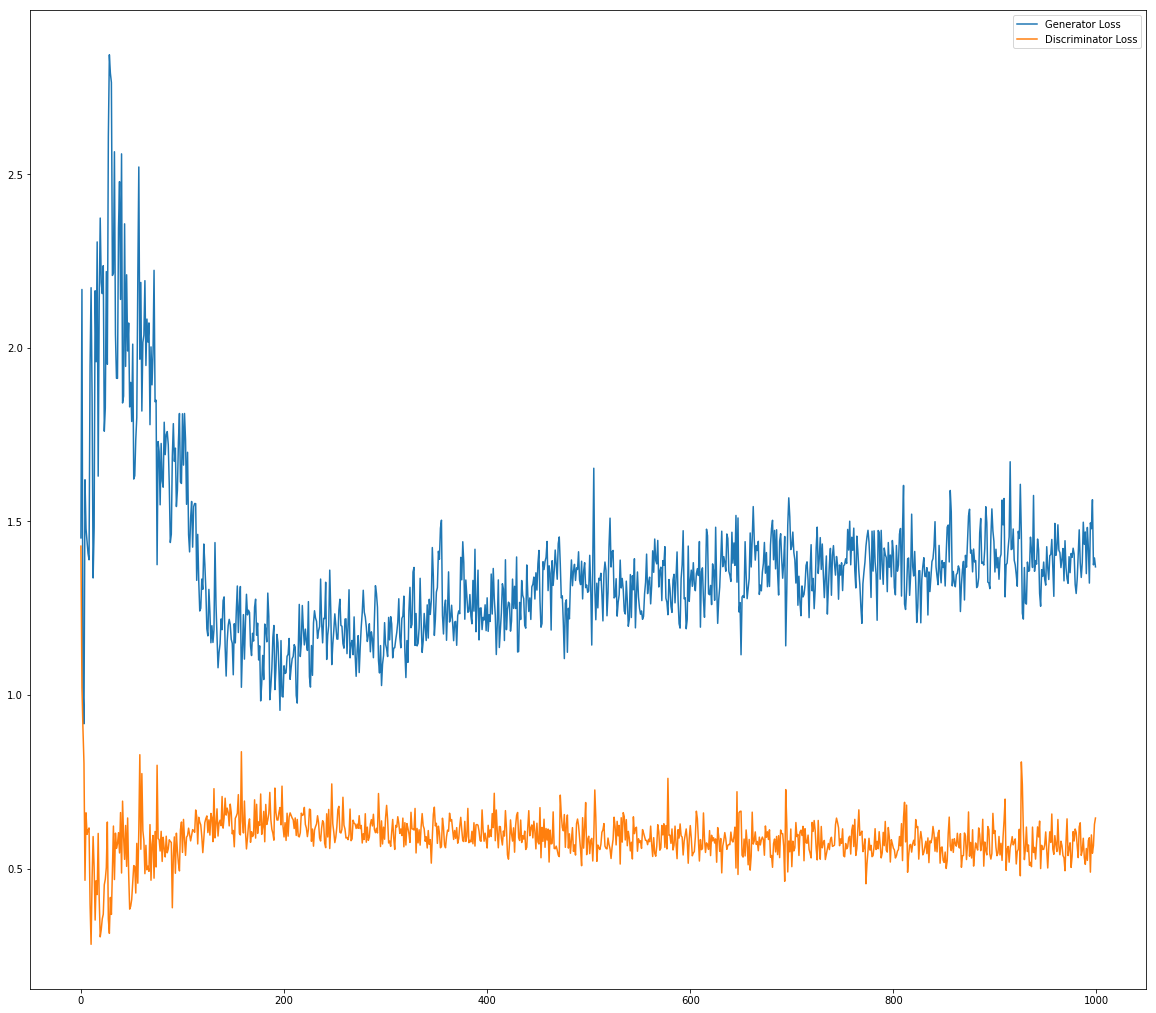

In [12]:
plt.figure(figsize=(20, 18))
plt.plot(train_loss_g, label="Generator Loss");
plt.plot(train_loss_d, label="Discriminator Loss");
plt.legend();

## Plot Accuracy

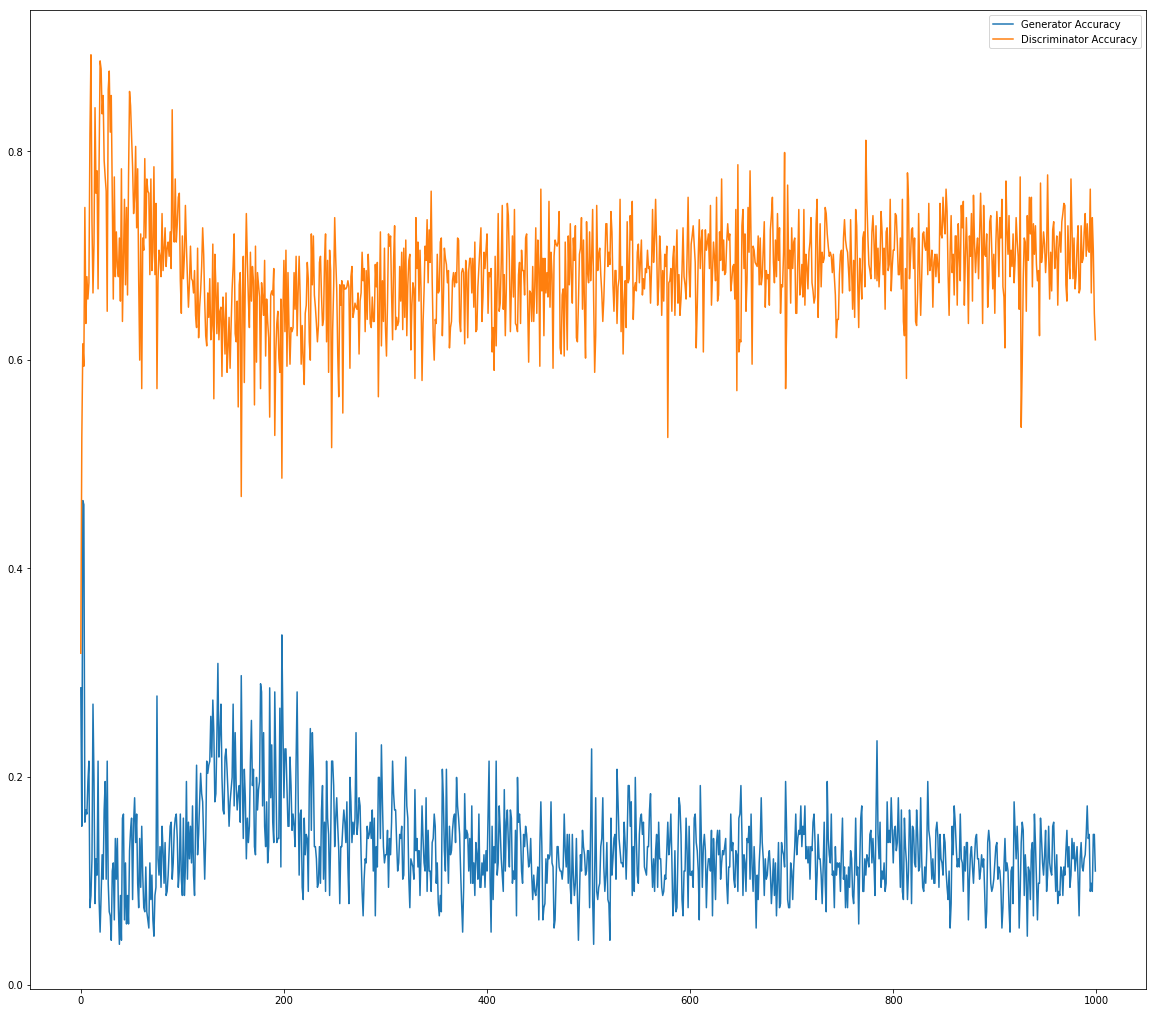

In [13]:
plt.figure(figsize=(20, 18))
plt.plot(train_acc_g, label="Generator Accuracy");
plt.plot(train_acc_d, label="Discriminator Accuracy");
plt.legend();

In [14]:
## save model
pth = os.path.join(models_path, 'gray-gan.h5')
gan.save(pth)

pth = os.path.join(models_path, 'gray-generator.h5')
generator.save(pth)

pth = os.path.join(models_path, 'gray-discriminator.h5')
discriminator.save(pth)